In [1]:
import yfinance as yf
import mplfinance as mpf

In [2]:
msft = yf.Ticker("MSFT")

# get historical market data
hist = msft.history(period="1y")

<IPython.core.display.Javascript object>

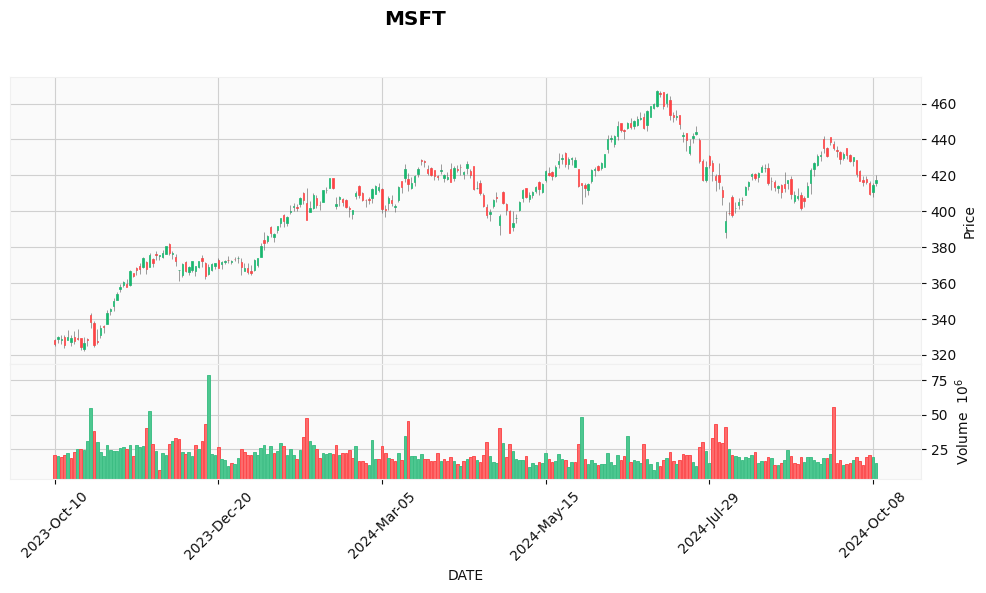

In [17]:
mpf.plot(hist,
        volume=True,
        style='yahoo',
        type='candle',
        figratio=(22,10),
        title='MSFT',
        ylabel='Price',
        #  savefig='../Presentation/img/shortmav_graph.png',
        xlabel='DATE')

In [4]:
import backtrader as bt

In [5]:
cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=hist)
cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)

In [6]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                    order.executed.value,
                    order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                        order.executed.value,
                        order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


In [7]:
cerebro.addstrategy(TestStrategy)

0

In [8]:
print('Starting Portfolio Value: %.2f $' % cerebro.broker.getvalue())

cerebro.run()

print('Final Portfolio Value: %.2f $' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00 $
2023-10-10, Close, 325.94
2023-10-11, Close, 329.94
2023-10-12, Close, 328.69
2023-10-13, Close, 325.29
2023-10-13, BUY CREATE, 325.29
2023-10-16, BUY EXECUTED, Price: 328.58, Cost: 328.58, Comm 0.33
2023-10-16, Close, 330.16
2023-10-17, Close, 329.59
2023-10-18, Close, 327.65
2023-10-19, Close, 328.85
2023-10-20, Close, 324.24
2023-10-23, Close, 326.87
2023-10-23, SELL CREATE, 326.87
2023-10-24, SELL EXECUTED, Price: 328.83, Cost: 328.58, Comm 0.33
2023-10-24, OPERATION PROFIT, GROSS 0.25, NET -0.41
2023-10-24, Close, 328.07
2023-10-25, Close, 338.13
2023-10-26, Close, 325.45
2023-10-27, Close, 327.35
2023-10-30, Close, 334.80
2023-10-31, Close, 335.59
2023-11-01, Close, 343.49
2023-11-02, Close, 345.72
2023-11-03, Close, 350.17
2023-11-06, Close, 353.87
2023-11-07, Close, 357.84
2023-11-08, Close, 360.49
2023-11-09, Close, 358.00
2023-11-10, Close, 366.92
2023-11-13, Close, 363.95
2023-11-14, Close, 367.51
2023-11-15, Close, 367.66
2023-11-16, Cl

In [11]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 4 Axes>]]

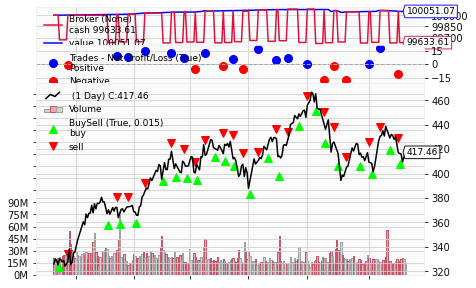

In [16]:
cerebro.plot()